# ZINFANDEL

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import riesling
!rm -f zin*.h5

In [14]:
phantom_settings='--shepp_logan --channels=8'
gap=4
nogap='zin-nogap'
blank=f'zin-blank{gap}'
trim=f'zin-trim{gap}'
os=2.0
recon_settings=f'--kernel=KB3 --os={os} --sdc={nogap}-sdc.h5'

First create the phantom. We do this three ways:
1 - With no gap as a reference
2 - With samples in the dead-time gap blanked (set to zero)
3 - With samples in the dead-time gap removed entirely. This is needed for some of the iterative reconstructions, because we don't want to sample points in k-space that aren't acquired.
We also estimate the density compensation for use in various places.

In [15]:
!riesling phantom {nogap} {phantom_settings}
!riesling phantom {blank} {phantom_settings} --blank={gap}
!riesling phantom {trim} {phantom_settings} --trim={gap}
!riesling sdc {nogap}.h5 --sdc=pipe

Non-iterative reconstruction to demonstrate the dead-time gap artefact

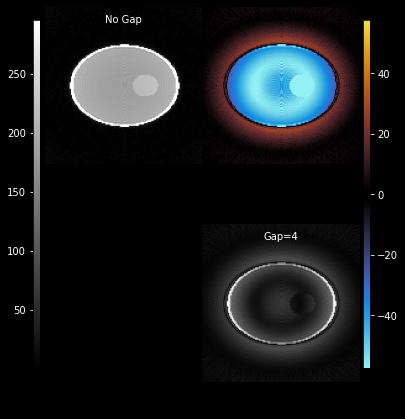

In [16]:

!riesling recon {nogap}.h5 {recon_settings}
!riesling recon {blank}.h5 {recon_settings}
riesling.images.diffN([f'{nogap}-recon.h5', f'{blank}-recon.h5'], titles=['No Gap', f'Gap={gap}'])

First, try filling the dead-time gap with a projection GRAPPA type method. This is implemented in the basic `zinfandel` command and is compatible with non-iterative reconstruction. Note that we run this on the `nogap` data-set because the trajectory points must be present to enable the algorithm - the k-space data in the gap is not used and will be overwritten in the output.

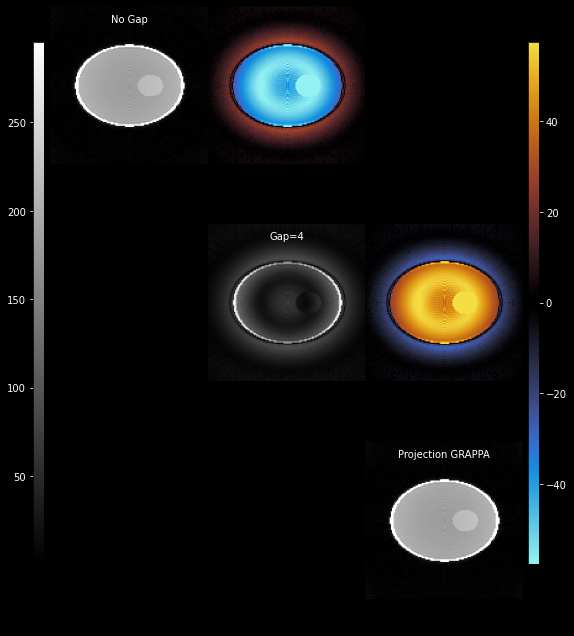

In [17]:
!riesling zinfandel {blank}.h5 --gap=4 -o zin-grappa
!riesling recon zin-grappa-zinfandel.h5 {recon_settings}
riesling.images.diffN([f'{nogap}-recon.h5', f'{blank}-recon.h5', 'zin-grappa-zinfandel-recon.h5'], titles=['No Gap', f'Gap={gap}', 'Projection GRAPPA'])

Let's compare the k-spaces

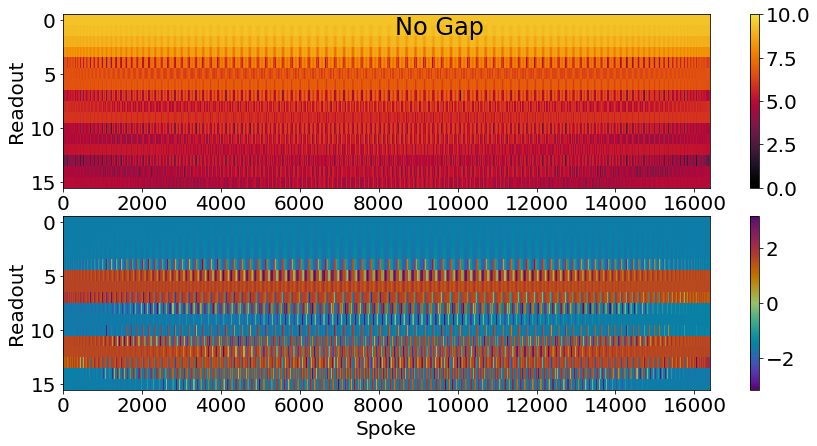

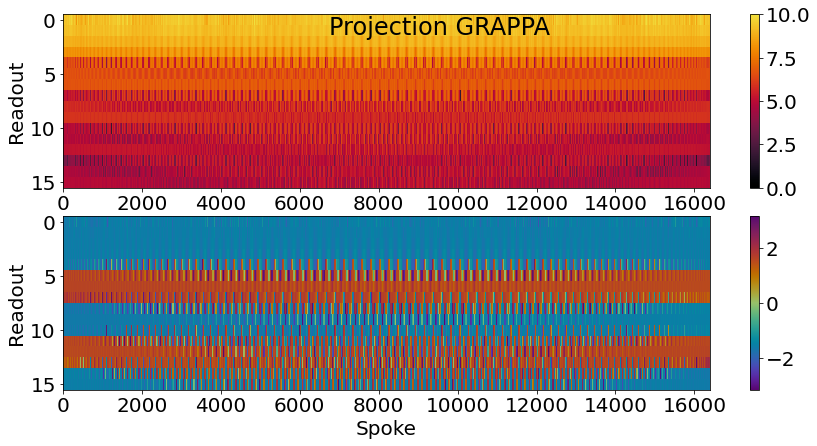

In [32]:
sl_read=slice(0,16)
sl_spk=slice(0,1024)
display(riesling.plots.kspace(f'{nogap}.h5', title='No Gap', sl_read=sl_read, clim=(0,10)))
display(riesling.plots.kspace('zin-grappa-zinfandel.h5', title='Projection GRAPPA', sl_read=sl_read, clim=(0,10)))


Now let's swap to comparing inverse problem / iterative reconstruction methods. First, let's extract SENSE maps from the gap-free data and reconstruct both the gap-free and the trimmed data (which will need its own SDC)

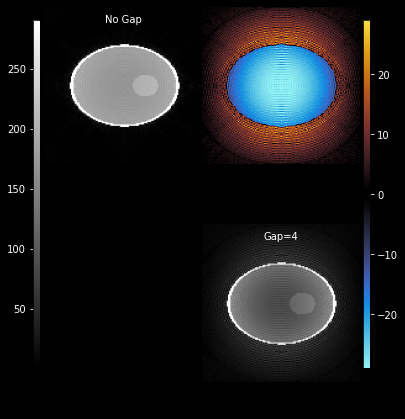

In [20]:
!riesling sense-calib {nogap}.h5 --sdc={nogap}-sdc.h5
!riesling cg {nogap}.h5 {recon_settings} --sense={nogap}-sense.h5
!riesling cg {trim}.h5 --os={os} --sense={nogap}-sense.h5 --sdc=pipe
riesling.images.diffN([f'{nogap}-cg.h5', f'{trim}-cg.h5'], titles=['No Gap', f'Gap={gap}'])

And let's see the k-spaces. We need to specify the blanked trajectory.

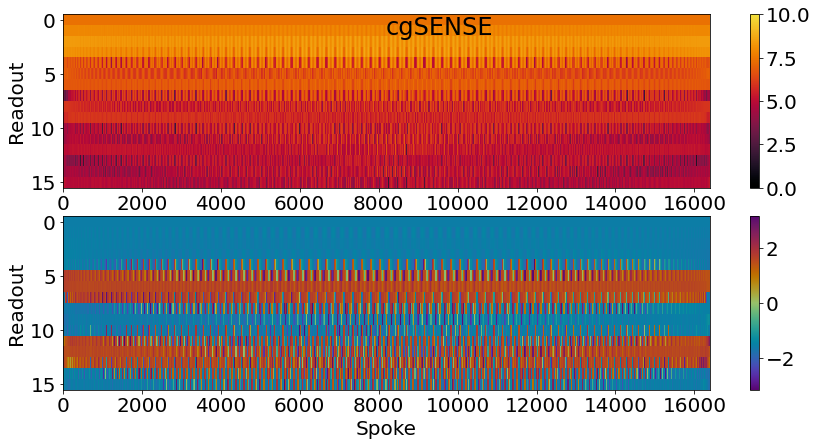

In [33]:
!riesling recon {trim}-cg.h5 --fwd --traj={blank}.h5 {recon_settings} --sense={nogap}-sense.h5
riesling.plots.kspace(f'{trim}-cg-recon.h5', title='cgSENSE', sl_read=sl_read, clim=(0,10))